In [1]:
%matplotlib inline
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.fftpack import fft
import krotov
import scipy
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')
import os

F:\Anaconda\lib\site-packages\qutip\__init__.py:83: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.13.
  .format(_cy_require, _Cython.__version__)


In [2]:
B =0 #In mG
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
Δ_hfs = 3*702.4*B
F_3 = 3.845*(10**14)

#Guessing the laser pulse
def Omega_P1(t, args):
    """Guess for the real part of the pump pulse"""
    Ω0 = 10**10
    return Ω0 * krotov.shapes.blackman(t, t_start=1*10**(-6), t_stop=5.0*10**(-6))


def Omega_P2(t, args):
    """Guess for the imaginary part of the pump pulse"""
    return 0.0


def Omega_S1(t, args):
    """Guess for the real part of the Stokes pulse"""
    Ω0 = 10**10
    return Ω0 * krotov.shapes.blackman(t, t_start=0.0, t_stop=4*10**(-6))


def Omega_S2(t, args):
    """Guess for the imaginary part of the Stokes pulse"""
    return 0.0

In [3]:
def hamiltonian():
    """Lambda-system Hamiltonian in the RWA"""

    # detunings
    ΔP = -10**9#E1 + omega_P - E2
    ΔS = -ΔP #E3 + omega_S - E2

    H0 = Qobj([[0.0, 0.0, 0.0], [0.0,ΔS, 0.0], [0.0, 0.0,0.0]])

    HP_re = -0.5 * Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
    HP_im = -0.5 * Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])

    HS_re = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
    HS_im = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])

    return [
        H0,
        [HP_re, Omega_P1],
        [HP_im, Omega_P2],
        [HS_re, Omega_S1],
        [HS_im, Omega_S2],
    ]
H = hamiltonian()#0,hfs+Δ_hfs,F_3

In [4]:
ket1 = qutip.Qobj(np.array([1.0, 0.0, 0.0]))
ket2 = qutip.Qobj(np.array([0.0, 1.0, 0.0]))
ket3 = qutip.Qobj(np.array([0.0, 0.0, 1.0]))

In [5]:
def rwa_target_state(ket3, T=5*10**(-6)):
    return np.exp(1j * (3.845*(10**14) + 10**9) * T) * ket3
psi_target = rwa_target_state(ket3)

In [6]:
#Control objective
objective = krotov.Objective(initial_state=ket1, target=psi_target, H=H)
objective

Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₁[3,3], u₁(t)], [H₂[3,3], u₂(t)], [H₃[3,3], u₃(t)], [H₄[3,3], u₄(t)]]]

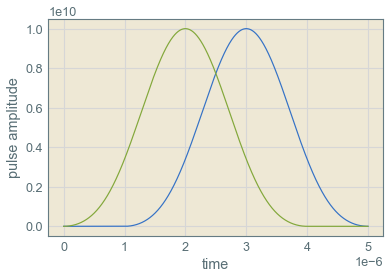

In [7]:
tlist = np.linspace(0, 5*10**(-6), 5000)
def plot_pulse(pulse1,pulse2, tlist, label):
    fig, ax = plt.subplots()
    pulse = tlist
    if callable(pulse1) and callable(pulse2):
        pulse1 = np.array([pulse1(t, args=None) for t in tlist])
        pulse2 = np.array([pulse2(t, args=None) for t in tlist])
    ax.plot(tlist, pulse1,label="pump")
    ax.plot(tlist, pulse2,label="Stokes")
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)
plot_pulse(H[1][1],H[3][1], tlist, '$\Omega$')
#plot_pulse(H[3][1], tlist, 'Ωₛ')

In [8]:
assert np.all([H[2][1](t, None) == 0 for t in tlist])
assert np.all([H[4][1](t, None) == 0 for t in tlist])

In [9]:
proj1 = qutip.ket2dm(ket1)
proj2 = qutip.ket2dm(ket2)
proj3 = qutip.ket2dm(ket3)
guess_dynamics = objective.mesolve(tlist, e_ops=[proj1,proj2,proj3])

In [10]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='1')
    ax.plot(result.times, result.expect[1], label='2')
    ax.plot(result.times, result.expect[2], label='3')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

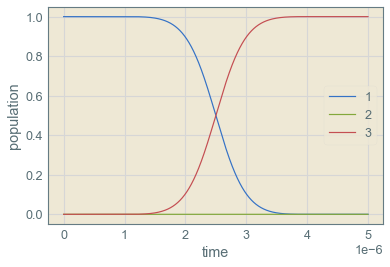

In [11]:
plot_population(guess_dynamics)